It is a follow-up notebook to "Fine-tuning ResNet34 on ship detection" (https://www.kaggle.com/iafoss/fine-tuning-resnet34-on-ship-detection/notebook) and "Unet34 (dice 0.87+)" (https://www.kaggle.com/iafoss/unet34-dice-0-87/notebook) that shows how to evaluate the solution and submit predictions. Please check these notebooks for additional details.

# FineTuning

In [1]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="4"
print("Loading Fast.AI modules...")
from fastai.conv_learner import *
from fastai.dataset import *
print("Pandas..")
import pandas as pd
print("Numpy..")
import numpy as np
print("SKLearn..")
from sklearn.model_selection import train_test_split
print("Setting variables...")
DATASET_ROOT = '/media/ssd-data/datasets/airbus/'
#DATASET_ROOT = '/media/data/dev/datasets/airbus/'
PATH = DATASET_ROOT
TRAIN = DATASET_ROOT + 'train/'
TEST = DATASET_ROOT + 'test/'
SEGMENTATION = DATASET_ROOT + 'train_ship_segmentations.csv'
PRETRAINED_DETECTION_PATH = DATASET_ROOT + 'fine-tuning-resnet34-on-ship-detection/models/'
PRETRAINED_SEGMENTATION_PATH = DATASET_ROOT + 'unet34-dice-0-87/models/'
DETECTION_TEST_PRED = DATASET_ROOT + 'fine-tuning-resnet34-on-ship-detection/ship_detection.csv'
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

nw = 4   #number of workers for data loader
arch = resnet34 #specify target architecture

train_names = [f for f in os.listdir(TRAIN)]
test_names = [f for f in os.listdir(TEST)]
for el in exclude_list:
    if(el in train_names): train_names.remove(el)
    if(el in test_names): test_names.remove(el)
#5% of data in the validation set is sufficient for model evaluation
tr_n, val_n = train_test_split(train_names, test_size=0.05, random_state=42)

class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        if self.sz == 768: return img 
        else: return cv2.resize(img, (self.sz, self.sz))
    
    def get_y(self, i):
        if(self.path == TEST): return 0
        masks = self.segmentation_df.loc[self.fnames[i]]['EncodedPixels']
        if(type(masks) == float): return 0 #NAN - no ship 
        else: return 1
    
    def get_c(self): return 2 #number of classes
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(20, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    #print(md)
    #md.is_multi = False
    return md

Setting CUDA devices...
Loading Fast.AI modules...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Pandas..
Numpy..
SKLearn..
Setting variables...


In [4]:
print(TEST)

/media/ssd-data/datasets/airbus/test/


In [5]:
sz = 256 #image size
bs = 128 #batch size

md = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learn.opt_fn = optim.Adam

False


 71%|███████▏  | 551/772 [06:09<02:28,  1.49it/s, loss=1.05] 

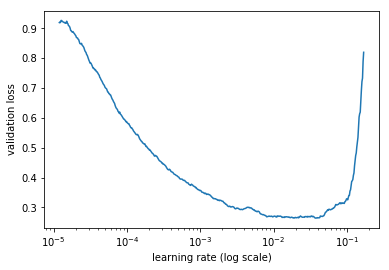

In [6]:
print(md.is_multi)
learn.lr_find()
learn.sched.plot()

In [7]:
learn.fit(2e-3, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.205765   0.181019   0.93236   


[array([0.18102]), 0.9323597231065192]

In [8]:
#Unfreeze the model and train it with differential learning rate. The lr of the head part is still 2e-3,
# while the middle layers of the model a trained with 5e-4 lr, and the base is trained with even smaller
# lr, 1e-4, since low level detector do not vary much from one image data set to another.
learn.unfreeze()
lr=np.array([1e-4,5e-4,2e-3])

The training has been run with learning rate annealing. Periodic lr increase followed by slow decrease drives the system out of steep minima (when lr is high) towards broader ones (which are explored when lr decreases) that enhances the ability of the model to generalize and reduces overfitting. Due to time limit, only once cycle has been run. But ideally several cycles must be run with gradual increase of the image size, etc. 256x256, 384x384, 768x768, to reach better performance of the model.
# TODO : run with different size

In [9]:
learn.fit(lr, 1, cycle_len=2, use_clr=(20,8))

epoch      trn_loss   val_loss   accuracy                    
    0      0.121111   0.107058   0.962913  
    1      0.089307   0.075825   0.972905                     


[array([0.07583]), 0.9729054571114348]

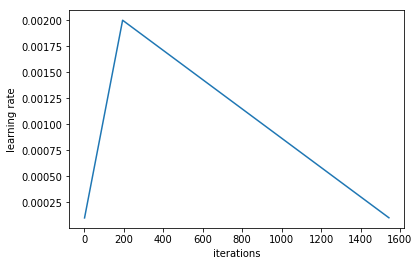

In [10]:
learn.save('Resnet34_lable_256_1')
learn.sched.plot_lr()

## Prediction

In [11]:
log_preds,y = learn.predict_with_targs(is_test=True)
probs = np.exp(log_preds)[:,1]
pred = (probs > 0.5).astype(int)
df = pd.DataFrame({'id':test_names, 'p_ship':probs})
df.to_csv('ship_detection.csv', header=True, index=False)

### Training on high resolution images
Since each epoch on higher resolution images, like 384x384 or 768x768, takes quite long time, training the model from scratch on these images is quite inefficient. Fortunately, modern convolutional nets support input images of arbitrary resolution. To decrease the training time, one can start training the model on low resolution images first and continue training on higher resolution images for only a few epochs. In addition, a model pretrained on low resolution images first generalizes better since a pixel information is less available and high order features are tended to be used.

In [2]:
sz = 384 #image size
bs = 64  #batch size : 64 x 384 => 8GiB

md = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learn.opt_fn = optim.Adam
learn.unfreeze()
lr=np.array([1e-4,5e-4,2e-3])

In [3]:
learn.load('Resnet34_lable_256_1')

In [ ]:
# Choose GPU
# learn.models.model = torch.nn.DataParallel(learn.models.model,device_ids=[3, 4, 5, 6])

learn.fit(lr/2, 1, cycle_len=2, use_clr=(20,8)) #lr is smaller since bs is only 32
learn.save('Resnet34_lable_384_1')

epoch      trn_loss   val_loss   accuracy                       
    0      0.098905   0.082586   0.970023  
  9%|▊         | 133/1544 [01:36<17:05,  1.38it/s, loss=0.0826]

## Trying SGDR to increase accuracy
Score de IAfoss :
epoch      trn_loss   val_loss   accuracy                       
    0      0.098905   0.082586   0.970023

In [3]:
sz = 384 #image size
bs = 64  #batch size : 64 x 384 => 8GiB

md = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learn.opt_fn = optim.Adam
learn.unfreeze()
lr=np.array([1e-4,5e-4,2e-3])

learn.load('Resnet34_lable_384_1')
learn.fit(lr,3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                       
    0      0.081691   0.065559   0.976364  
    1      0.103968   0.073832   0.975019                       
    2      0.069218   0.06222    0.979247                       
    3      0.096118   0.081181   0.974058                       
    4      0.08939    0.066498   0.977325                       
    5      0.062333   0.056755   0.981937                       
    6      0.057263   0.054618   0.982706                       



[array([0.05462]), 0.9827056110684089]

In [4]:
learn.save('Resnet34_384_7')

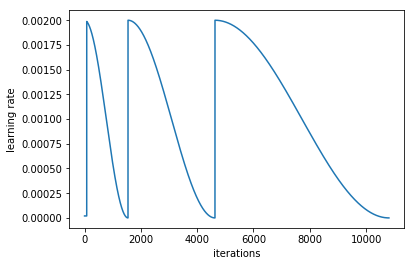

In [7]:
learn.sched.plot_lr()
#learn.sched.plot()

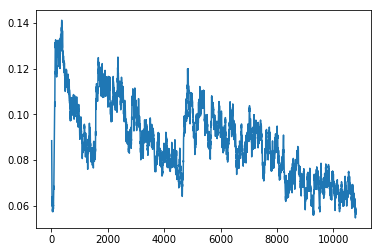

In [6]:
learn.sched.plot_loss()

In [2]:
sz = 768 #image size
bs = 16  #batch size : 16 x 768 => 8GiB

md = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learn.opt_fn = optim.Adam
learn.unfreeze()
lr=np.array([1e-4,5e-4,2e-3])

learn.load('Resnet34_384_7')
learn.fit(lr,3, cycle_len=1, cycle_mult=2)
learn.save('Resnet34_768_7')

epoch      trn_loss   val_loss   accuracy                         
    0      0.096812   0.088213   0.970215  
    1      0.177091   0.142851   0.964835                        
    2      0.117592   0.132531   0.971176                         
    3      0.135203   0.202487   0.966372                        
    4      0.132338   0.10947    0.967333                         
    5      0.123738   0.175934   0.967333                         
    6      0.103259   1.175456   0.965603                         



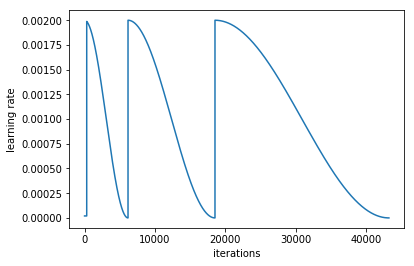

In [3]:
learn.sched.plot_lr()

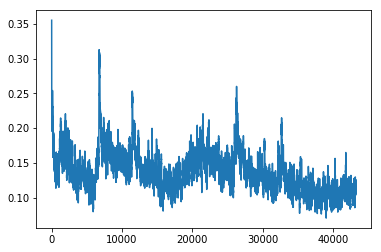

In [4]:
learn.sched.plot_loss()